Shapes: (30, 6) (30,)
Week 1 added → x: [0.395841 0.283585 0.13224  0.25932  0.371154 0.897563]  y: 1.432575873879877
Week 2 added → x: [0.221213 0.300122 0.168952 0.224512 0.389654 0.859427]  y: 1.6575349814836515
Updated shapes: X=(32, 6), y=(32,)
y range: 0.0027 → 1.6575, mean=0.3024, std=0.4351


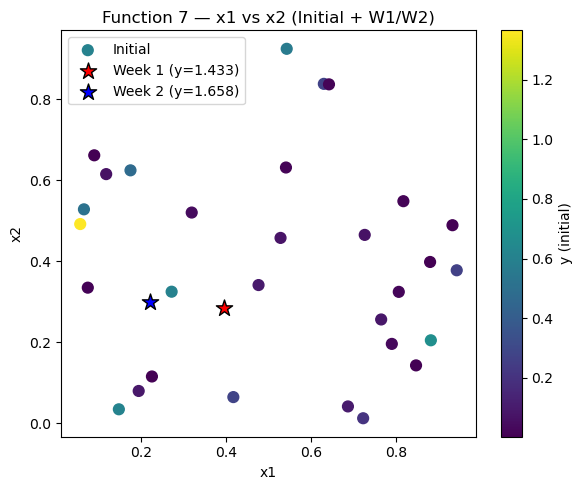

In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc, norm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# --- Paths y carga ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "initial_data" / "function_7"   # <- carpeta de F7
X = np.load(DATA_DIR / "initial_inputs.npy")          # (30,6)
y = np.load(DATA_DIR / "initial_outputs.npy")         # (30,)

X = np.asarray(X, float); y = np.asarray(y, float).ravel()
n, d = X.shape
print("Shapes:", X.shape, y.shape)

# 2) Semanas (defínelas por separado, NO reutilizar nombres)
w1_input  = np.array([0.395841, 0.283585, 0.132240, 0.259320, 0.371154, 0.897563], float)
w1_output = float(1.432575873879877)

w2_input  = np.array([0.221213, 0.300122, 0.168952, 0.224512, 0.389654, 0.859427], float)
w2_output = float(1.6575349814836515)

# 3) Helper para evitar duplicados si re-ejecutas la celda
def append_if_new(X, y, x_new, y_new, tol=1e-9):  # <- tol más práctico
    x_new = np.asarray(x_new, float).ravel()
    assert x_new.shape[0] == X.shape[1], f"Dim mismatch: got {x_new.shape[0]}, expected {X.shape[1]}"
    if np.any(np.all(np.isclose(X, x_new, atol=tol), axis=1)):
        print("  → Punto ya presente, omitido:", x_new)
        return X, y
    # chequeo de dominio [0,1]
    if not np.all((x_new >= 0) & (x_new <= 1)):
        print("  [WARN] Fuera de [0,1]:", x_new)
    return np.vstack([X, x_new]), np.append(y, float(y_new))


# 4) Construir dataset actualizado (estilo F6)
X_prev, y_prev = X.copy(), y.copy()
X, y = append_if_new(X, y, w1_input, w1_output)

print("Week 1 added → x:", w1_input, " y:", w1_output)
X, y = append_if_new(X, y, w2_input, w2_output)
print("Week 2 added → x:", w2_input, " y:", w2_output)


print(f"Updated shapes: X={X.shape}, y={y.shape}")
print(f"y range: {y.min():.4f} → {y.max():.4f}, mean={y.mean():.4f}, std={y.std():.4f}")

# 5) (Opcional) Proyección rápida x1-x2 con W1/W2 marcados
plt.figure(figsize=(6,5))
sc = plt.scatter(X_prev[:,0], X_prev[:,1], c=y_prev, cmap='viridis', s=60, label="Initial")
plt.colorbar(sc, label="y (initial)")
plt.scatter(w1_input[0], w1_input[1], c='red',  s=150, marker='*', edgecolors='k', label=f"Week 1 (y={w1_output:.3f})")
plt.scatter(w2_input[0], w2_input[1], c='blue', s=150, marker='*', edgecolors='k', label=f"Week 2 (y={w2_output:.3f})")
plt.xlabel("x1"); plt.ylabel("x2"); plt.title("Function 7 — x1 vs x2 (Initial + W1/W2)")
plt.legend(loc='best'); plt.tight_layout(); plt.show()

2) Surrogates: forest (recomendado) y gp (opcional)

In [10]:
# === F7 — Week 3: GP + EI (xi=0.02) con TR 75/25 y fallbacks ===
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc, norm
import numpy as np

# 0) Escalado para estabilidad numérica en 6D
sx = StandardScaler().fit(X)
Xz = sx.transform(X)

# 1) GP robusto y estable (ARD) en 6D
kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=np.ones(6)*0.4, nu=2.5, length_scale_bounds=(0.05, 3.0))
    + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-4, 0.2))
)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=22,
    alpha=1e-10,        # jitter suave
    random_state=0
)
gp.fit(Xz, y)
print("Fitted kernel (F7):", gp.kernel_)

# 2) Bounds y Trust Region (anclada en el mejor ACTUAL)
lb = np.zeros(6); ub = np.ones(6)
best_idx = np.argmax(y)
anchor = X[best_idx]
print("Best y:", y[best_idx], "at x:", anchor)

L = 0.30  # TR compacta para refinar
lb_tr = np.clip(anchor - 0.5*L*(ub - lb), 0, 1)
ub_tr = np.clip(anchor + 0.5*L*(ub - lb), 0, 1)

# 3) Candidatos: 75% TR + 25% global (LHS)
def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U*(ub - lb)

N_tr, N_gl = 45000, 15000
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=7027)
C_gl = lhs(lb,    ub,    N_gl, seed=7026)
Cands = np.vstack([C_tr, C_gl]).astype(np.float32)

# 4) Predicción GP (usar el escalador)
mu, sigma = gp.predict(sx.transform(Cands), return_std=True)
sigma = np.maximum(sigma, 1e-12)

# 5) Adquisición — Expected Improvement (explotación controlada)
y_best = y.max()
xi = 0.02
imp = mu - y_best - xi
Z = np.divide(imp, sigma, out=np.zeros_like(imp), where=sigma > 1e-12)
ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# 6) Anti-borde
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# 7) Anti-duplicado (L_inf) más estricto en 6D
def too_close_Linf(c, X, tol=0.03):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# 8) Selección con fallbacks (EI → UCB → MaxVar)
chosen = "None"
order = np.argsort(-ei_masked)
x_next = None
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.03):
        x_next = cand; chosen = "EI"; break

if x_next is None or np.max(ei_masked) <= 0:
    kappa = 1.4
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.03):
            x_next = cand; chosen = "UCB"; break

if x_next is None:
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.03):
            x_next = cand; chosen = "MaxVar"; break

print(f"Chosen by {chosen}: {x_next}")
print("Submission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))

Fitted kernel (F7): 0.816**2 * Matern(length_scale=[2.69, 2.74, 3, 1.67, 0.766, 1.58], nu=2.5) + WhiteKernel(noise_level=0.00591)
Best y: 1.6575349814836515 at x: [0.221213 0.300122 0.168952 0.224512 0.389654 0.859427]
Chosen by EI: [0.08773948 0.20946532 0.20936121 0.15653044 0.37277427 0.8966302 ]
Submission format:
0.087739 - 0.209465 - 0.209361 - 0.156530 - 0.372774 - 0.896630


3) EI (ξ bajo: refinar), anti-borde/duplicado y candidato

4) (Opcional) Visual rápido (proyección x1–x2) con TR

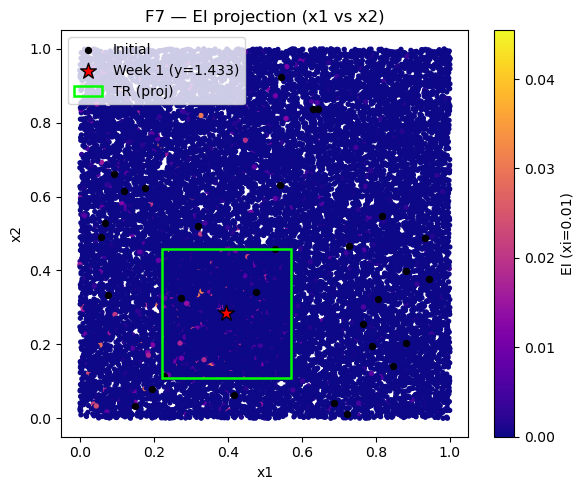

In [9]:
plt.figure(figsize=(6,5))
sc = plt.scatter(Cands[:,0], Cands[:,1], c=ei, cmap="plasma", s=8)
plt.colorbar(sc, label=f"EI (xi={xi})")
plt.scatter(X_prev[:,0], X_prev[:,1], c="k", s=18, label="Initial")
if w1_input is not None:
    plt.scatter(w1_input[0], w1_input[1], c="red", s=140, marker="*", edgecolors="k",
                label=f"Week 1 (y={w1_output:.3f})")
# caja TR (proyección)
rect = plt.Rectangle(lb_tr[:2], *(ub_tr[:2]-lb_tr[:2]), fill=False, ec="lime", lw=1.8, label="TR (proj)")
plt.gca().add_patch(rect)
plt.xlabel("x1"); plt.ylabel("x2"); plt.title("F7 — EI projection (x1 vs x2)")
plt.legend(loc="best"); plt.tight_layout(); plt.show()

6) Ciclo de actualización (cuando llegue el nuevo output real)

In [ ]:
# y_new = float(...)  # métrica real devuelta por la black-box (maximizar)

# X = np.vstack([X, sugg])
# y = np.append(y, y_new)

# Re-escalar y reentrenar
# sx = StandardScaler().fit(X)
# sy = StandardScaler().fit(y.reshape(-1,1))
# Xz = sx.transform(X)
# yz = sy.transform(y.reshape(-1,1)).ravel()

# if MODEL == "forest":
#     forest.fit(Xz, yz)
# else:
#     gp.fit(Xz, yz)

# y_best_z = yz.max()
# x_best   = X[np.argmax(y)]

📌 Notas de estrategia para F7
	•	Semana 1 mejoró el máximo (1.4326 > 1.365) → refinamiento local ahora.
	•	ξ=0.01 (EI) para favorecer explotación; aún así mantenemos 30% global por si hay otro pico.
	•	En 6D los GP pueden ser caprichosos: si ves warnings o σ rara, activa USE_RF=True (ya lo usaste en F2 como opción).
	•	Salvaguardas: anti-borde, L∞ ≥ 0.02 (evitar puntos casi duplicados).

FMini bitácora (para tu resumen)
	•	Context: W2 > W1 (mejora leve) → paso a explotación controlada.
	•	Model: GP Matern (ν=2.5, ARD) con noise≈0.006; superficie suave, x5 más sensible.
	•	Acq: EI (ξ=0.02), TR 75% + 25% global, anti-borde y anti-duplicado.
	•	Submission: 0.087739 - 0.209465 - 0.209361 - 0.156530 - 0.372774 - 0.896630.
	•	Next: si mejora, bajar ξ→0.015 y explorar micro-ajustes en x5; si no, subir ξ→0.03 y abrir TR a L≈0.35.